In [7]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from sklearn import preprocessing
from sklearn.decomposition import PCA

In [8]:
# Load data
train_feature = pd.read_csv("../../Data/Mechanisms of Action (MoA) Prediction/train_features.csv")
test_feature = pd.read_csv("../../Data/Mechanisms of Action (MoA) Prediction/test_features.csv")
train_targets_scored = pd.read_csv("../../Data/Mechanisms of Action (MoA) Prediction/train_targets_scored.csv")
train_targets_nonscored = pd.read_csv("../../Data/Mechanisms of Action (MoA) Prediction/train_targets_nonscored.csv")
sub = pd.read_csv('../../Data/Mechanisms of Action (MoA) Prediction/sample_submission.csv')


In [9]:
train_feature.info()
train_feature.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23814 entries, 0 to 23813
Columns: 876 entries, sig_id to c-99
dtypes: float64(872), int64(1), object(3)
memory usage: 159.2+ MB


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [10]:
GENES = [col for col in train_feature.columns if col.startswith('g-')]
CELLS = [col for col in train_feature.columns if col.startswith('c-')]
len(GENES+CELLS)

872

## Choosing PCA on Genes columns
Don’t do it. Don’t choose the number of components manually.Instead of that, use the option that allows you to set the variance of the input that is supposed to be explained by the generated components.

Remember to scale the data to the range between 0 and 1 before using PCA!

Typically, we want the explained variance to be between 95–99%.

In [11]:
from sklearn.preprocessing import QuantileTransformer

In [12]:
for col in tqdm(GENES + CELLS):
    transformer = QuantileTransformer(random_state=0, output_distribution="normal")
    vec_len = len(train_feature[col].values)
    vec_len_test = len(test_feature[col].values)
    raw_vec = train_feature[col].values.reshape(vec_len, 1)
    transformer.fit(raw_vec)

    train_feature[col] = transformer.transform(raw_vec).reshape(1, vec_len)[0]
    test_feature[col] = transformer.transform(test_feature[col].values.reshape(vec_len_test, 1)).reshape(1, vec_len_test)[0]
    
df = pd.concat([pd.DataFrame(train_feature[GENES]), pd.DataFrame(test_feature[GENES])])

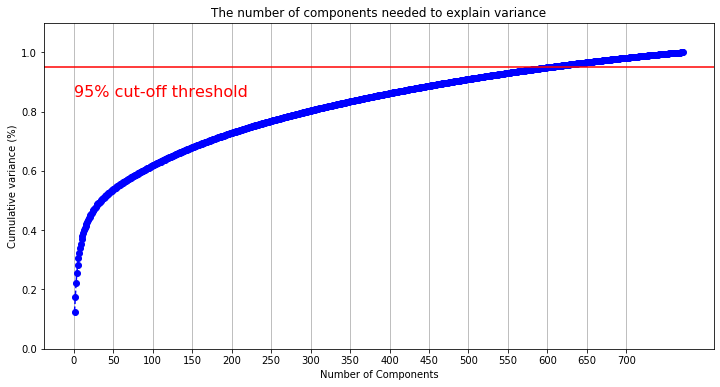

In [14]:
pca = PCA().fit(df)

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 773, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 750, step=50)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()